# 在未标记的数据集上进行预训练

In [1]:
import matplotlib.pyplot as plt
import tiktoken
import torch

from previous_chapters import *

# 0. 模型配置

In [37]:
model_config = {
    "vocab_size": 50257,
    "ctx_len": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.1,
    "with_bias": False,
    "with_mask": True
}

torch.manual_seed(123)

## 1. 生成文本

实现两个辅助函数以双向转换token ids和tokens


In [19]:
def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    token_ids = torch.tensor(token_ids).reshape(1, -1)
    # token_ids = torch.Tensor(token_ids).unsqueeze(0)
    return token_ids

def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    token_ids = token_ids.reshape(-1).tolist()
    text = tokenizer.decode(token_ids)
    return text

调用GPT2Small和generate_text_simple函数以生成文本

In [39]:
model = GPT2Small(
    vocab_size=model_config["vocab_size"],
    ctx_len=model_config["ctx_len"],
    emb_dim=model_config["emb_dim"],
    n_heads=model_config["n_heads"],
    n_layers=model_config["n_layers"],
    dropout_rate=model_config["dropout_rate"],
    with_bias=model_config["with_bias"],
    with_mask=model_config["with_mask"]
)
model.eval()

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
input_ids = text_to_token_ids(start_context, tokenizer)
print(f"input ids' shape: {input_ids.shape}")
print(f"input token ids: \n{input_ids}\n")

output_ids = generate_text_simple(
    model=model,
    indices=input_ids,
    max_new_tokens=10,
    context_size=256
)
print(f"output ids' shape: {output_ids.shape}")
print(f"output_ids: \n{output_ids}")

output_text = token_ids_to_text(output_ids, tokenizer)
print(f"output text: \n{output_text}")

input ids' shape: torch.Size([1, 4])
input token ids: 
tensor([[6109, 3626, 6100,  345]])

output ids' shape: torch.Size([1, 14])
output_ids: 
tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])
output text: 
Every effort moves you rentingetic wasnم refres RexMeCHicular stren


# 2. 计算文本生成的好坏：多分类交叉熵损失函数和困惑度

## 2.1 多分类交叉熵损失函数
多分类交叉熵损失函数公式如下：
$$
L = \frac{1}{N}\sum_{i} L_i = - \frac{1}{N}\sum_{i} \sum_{c=1}^My_{ic}\log(p_{ic}) \\
$$

其中：
- M ——类别的数量
- y_{ic} ——符号函数（ 0 或 1 ），如果样本 i 的真实类别等于 c 取 1 ，否则取 0
- p_{ic} ——观测样本 i 属于类别 c 的预测概率

PyTorch已经实现了一个`cross_entropy`函数，可以直接使用。

In [40]:
# 先准备两个batch的输入张量：
input_texts = [
    "every effort moves",
    "I really like"
]
input_ids = torch.cat([text_to_token_ids(text, tokenizer) for text in input_texts])
print(input_ids)

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])


In [41]:
# 然后准备对应的两个目标输出张量：
target_texts = [
    " effort moves you",
    " really like chocolate"
]
target_ids = torch.cat([text_to_token_ids(text, tokenizer) for text in target_texts])
print(target_ids)

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


In [42]:
# 使用模型计算预测概率：
with torch.no_grad():
    logits = model(input_ids)
print(f"logits shape: {logits.shape}")
print(f"logits: {logits}")

logits shape: torch.Size([2, 3, 50257])
logits: tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])


In [43]:
# 调用entropy_loss函数计算交叉熵损失：
loss = torch.nn.functional.cross_entropy(logits, target_ids)

RuntimeError: Expected target size [2, 50257], got [2, 3]

In [44]:
# 如上所示，需要对logits和target_ids进行reshape操作，
# logits: (batch_size, num_tokens, vocab_size) -> (num_tokens_total, vocab_size)
# target_ids: (batch_size, num_tokens) -> (num_tokens_total,)
logits = logits.reshape(-1, logits.shape[-1])
targets = target_ids.reshape(-1)
print(f"logits shape: {logits.shape}")
print(f"targets shape: {targets.shape}")

logits shape: torch.Size([6, 50257])
targets shape: torch.Size([6])


In [45]:
# reshape之后再重新计算损失：
loss = torch.nn.functional.cross_entropy(logits, targets)
print(f"loss is: {loss}")

loss is: 10.793963432312012


## 2.2 困惑度
关于困惑度的在不同场合下的定义，可以参考：[困惑度(perplexity)的基本概念及多种模型下的计算（N-gram, 主题模型, 神经网络）](https://zhuanlan.zhihu.com/p/114432097)。

我们在这里只需要简单地认为困惑度就是交叉熵损失的指数函数的计算结果即可。

In [46]:
perplexity = torch.exp(loss)
print(f"perplexity is: {perplexity}")

perplexity is: 48725.7734375


# 3. 划分训练集和验证集
内容大纲：
1. 加载原始的文本数据集
2. 将原始的数据集划分为训练集和验证集
3. 实现损失计算

## 3.1 加载原始的文本数据集

In [47]:
import os 

corpus_file_path = "./the-verdict.txt"
with open(corpus_file_path, "r", encoding="utf-8") as f:
    corpus = f.read()

In [48]:
num_total_chars = len(corpus)
print(f"number of total characters: {num_total_chars}")

num_total_tokens = len(tokenizer.encode(corpus))
print(f"number of total tokens: {num_total_tokens}")

number of total characters: 20479
number of total tokens: 5145


## 3.2 将原始的数据集划分为训练集和验证集

In [49]:
train_ratio = 0.9 ## 训练集占总数据量的比例
split_idx = int(train_ratio * len(corpus))
train_set = corpus[:split_idx]
valid_set = corpus[split_idx:]

In [50]:
assert round(len(train_set) / len(valid_set)) == 9

In [51]:
torch.manual_seed(123)

# 加载训练集：
train_loader = create_dataloader_v1(
    txt=train_set,
    batch_size=2,
    max_length=model_config["ctx_len"],
    stride=model_config["ctx_len"],
    drop_last=True,
    shuffle=True
)

# 加载验证集：
valid_loader = create_dataloader_v1(
    txt=valid_set,
    batch_size=2,
    max_length=model_config["ctx_len"],
    stride=model_config["ctx_len"],
    drop_last=True,
    shuffle=True
)

In [52]:
# 检查数据是否能够正确加载：
print("train set loader:")
for x, t in train_loader:
    print(x.shape, t.shape)

print("valid set loader:")
for x, t in valid_loader:
    print(x.shape, t.shape)

train set loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
valid set loader:
torch.Size([2, 256]) torch.Size([2, 256])


## 3.3 实现损失计算

In [53]:
def calc_loss_batch(x_batch, t_batch, model: torch.nn.Module, device: torch.device):
    x_batch = x_batch.to(device)
    t_batch = t_batch.to(device)

    logits = model(x_batch)
    logits = logits.reshape(-1, logits.shape[-1])
    targets = t_batch.reshape(-1)
    loss = torch.nn.functional.cross_entropy(logits, targets)
    return loss


def calc_loss_epoch(dataloader, model, device, num_batches: int = None):
    loss_sum = 0.
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(len(dataloader), num_batches)
    
    for i, (x_batch, t_batch) in enumerate(dataloader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(x_batch, t_batch, model, device)
        loss_sum += loss
    loss_mean = loss_sum / num_batches
    return loss_mean

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(type(device))
model.to(device)

# 训练模型
train_loss = calc_loss_epoch(train_loader, model, device)
print(f"Train loss: {train_loss}")

# 验证模型
valid_loss = calc_loss_epoch(valid_loader, model, device)
print(f"Validation loss: {valid_loss}")

Train loss: 10.98758316040039
Validation loss: 10.981106758117676


# 4. 训练模型
内容大纲：
1. 实现模型验证
2. 生成文本
3. 实现模型训练
4. 可视化收敛情况

## 4.1 实现模型验证

In [55]:
def evaluate(model, train_loader, valid_loader, device, num_batches):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_epoch(train_loader, model, device, num_batches)
        valid_loss = calc_loss_epoch(valid_loader, model, device, num_batches)
    model.train()
    return train_loss, valid_loss

In [56]:
train_loss, valid_losss = evaluate(model, train_loader, valid_loader, device, num_batches=2)
print(f"train_loss: {train_loss}, valid_loss: {valid_losss}")

train_loss: 10.991314888000488, valid_loss: 10.981106758117676


## 4.2 在经过一个epoch的训练之后生成预测文本

In [57]:
def generate_text(model, tokenizer, device, start_context) -> str:
    model.eval()
    ctx_size = model.tok_emb.weight.shape[0]
    input_ids = text_to_token_ids(start_context, tokenizer)
    with torch.no_grad():
        output_ids = generate_text_simple(
            model=model,
            indices=input_ids,
            max_new_tokens=50,
            context_size=ctx_size
        )
        predicted_text = token_ids_to_text(output_ids, tokenizer)
        print(predicted_text.replace("\n", " "))
    model.train()

## 4.3 实现模型训练

In [58]:
def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    num_batches,
    start_context
):
    train_losses = []  # 训练周期内所有的损失值
    valid_losses = []  # 训练周期内所有的损失值
    total_tokens_seen = []  # 训练周期内总共处理的token数
    tokens_seen = 0  # 当前epoch处理的token数
    global_step = 0  # 当前经过训练的样本数

    for e in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate(
                    model,
                    train_loader,
                    valid_loader,
                    device,
                    num_batches
                )
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                total_tokens_seen.append(tokens_seen)
                print(f"Epoch: {e}, Step: {global_step}, Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}")
        generate_text(model, tokenizer, device, start_context)
    return train_losses, valid_losses, total_tokens_seen

In [59]:
# 好了，现在可以预训练大模型了：
torch.manual_seed(123)
model = GPT2Small(
    vocab_size=model_config["vocab_size"],
    ctx_len=model_config["ctx_len"],
    emb_dim=model_config["emb_dim"],
    n_heads=model_config["n_heads"],
    n_layers=model_config["n_layers"],
    dropout_rate=model_config["dropout_rate"],
    with_bias=model_config["with_bias"],
    with_mask=model_config["with_mask"]
)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

num_epochs = 10
train_losses, valid_losses, total_tokens_seen = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    num_batches=5,
    start_context="Every effort moves you"
)

Epoch: 0, Step: 5, Train Loss: 9.272, Valid Loss: 9.539
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 1, Step: 10, Train Loss: 8.781, Valid Loss: 8.975
Epoch: 1, Step: 15, Train Loss: 8.294, Valid Loss: 8.497
Every effort moves you, the, the the the the the the the, the the, the, the, the the, the the,, the the the, the, the the the, the the the the the, the, the the, the, the the
Epoch: 2, Step: 20, Train Loss: 7.768, Valid Loss: 8.063
Epoch: 2, Step: 25, Train Loss: 7.184, Valid Loss: 7.656
Every effort moves you, the, the, the, the, the, the.                                     
Epoch: 3, Step: 30, Train Loss: 6.738, Valid Loss: 7.325
Epoch: 3, Step: 35, Train Loss: 6.275, Valid Loss: 7.061
Every effort moves you, and, and the the. ". ". ".   ", and the   " " I had the the the ". " ".  ". ", I
Epoch: 4, Step: 40, Train Loss: 5.885, Valid Loss: 6.908
Epoch: 4, Step: 45, Train Loss: 5.445, Valid Loss: 6.645
Every effort moves you, and I had the the of

## 4.4 可视化收敛情况

In [60]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # 绘制随着训练进行（epoch值增大）训练集损失和验证集损失的变化情况
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # 创建第二个x轴用于显示可观察的tokens
    ax2 = ax1.twiny()  # 创建一个共享相同y轴的第二个x轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 用于对齐刻度的不可见图表
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # 调整布局以节省空间
    plt.savefig("loss-plot.pdf")
    plt.show()

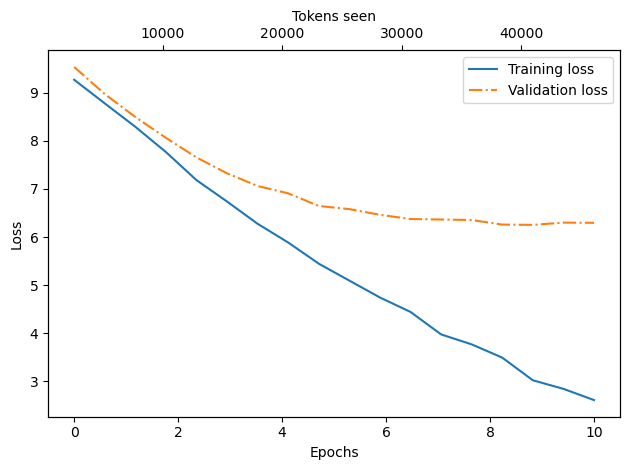

In [61]:

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, total_tokens_seen, train_losses, valid_losses)

# 5. 文本生成的多样性

In [62]:
# 原有的文本生成策略是每次都会从词表中选择概率最大的那个token返回：
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
for _ in range(10):
    output_ids = generate_text_simple(
        model=model,
        indices=text_to_token_ids("Every effort moves you", tokenizer=tokenizer),
        max_new_tokens=25,
        context_size=model_config["ctx_len"]
    )
    output_text = token_ids_to_text(output_ids, tokenizer=tokenizer)
    print(f"output text: {output_text}")

output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and to me to
output text: Every effort moves you know.
"I was a he was--I had a little to have to have to work, and t

如上所述，我们可以看到，对同一个上下文，重复生成的预测文本都是一样的。

## 5.1 可放回的多项式分布抽样

为了增加生成文本的多样性，我们可以使用`torch.multinomial`函数从多项式分布中进行放回抽样。

首先，我们构造一个只有9个单词的小型词汇表：

In [63]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inversed_vocab = {v: k for k, v in vocab.items()}

现在，假设输入的文本是“Every effort moves you”，
而模型返回的logits如下：


In [64]:
logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

这时候我们使用softmax函数将上述logits转换为概率分布，如下所示：

In [65]:
probs = torch.softmax(logits, dim=0)
next_token_id = torch.argmax(probs).item()
next_token = inversed_vocab[next_token_id]
print(f"next token: {next_token}")

next token: forward


OK，这是之前的文本生成策略，现在，我们把`torch.argmax`改为`torch.multinomial`，以实现从概率分布中采样得到下一个token：

In [66]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print("next token: ", inversed_vocab[next_token_id])

next token:  forward


为了验证使用多项式分布采样来获取下一个token的随机性，我们可以使用`torch.bincount`方法来统计多次采样的结果：

In [67]:
# 采样1000次：
samples = [torch.multinomial(probs, num_samples=1).item() for _ in range(1000)]
token_freqs = torch.bincount(torch.tensor(samples))
for i, f in enumerate(token_freqs):
    t = inversed_vocab[i]
    print(f"{t}: {f.item()}")

closer: 73
every: 0
effort: 0
forward: 581
inches: 2
moves: 0
pizza: 0
toward: 344


所以，我们可以不再使用`torch.argmax`来避免每次生成同样的tokens，而是使用`torch.multinomial`来从概率分布中随机采样。

## 5.2 温度缩放

In [68]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [69]:
# 定义三个温度缩放因子以作比较：
temperatures = [1, 0.1, 5]

# 计算经过上述缩放因子缩放的概率分布：
scaled_probs = [softmax_with_temperature(logits, t) for t in temperatures]
# print(f"scaled probs: \n{scaled_probs}")
# print(f"logits shape: {logits.shape}")
# print(f"scaled_probs' shape: {scaled_probs.shape}")

接着，我们画出三个缩放因子下的概率分布：

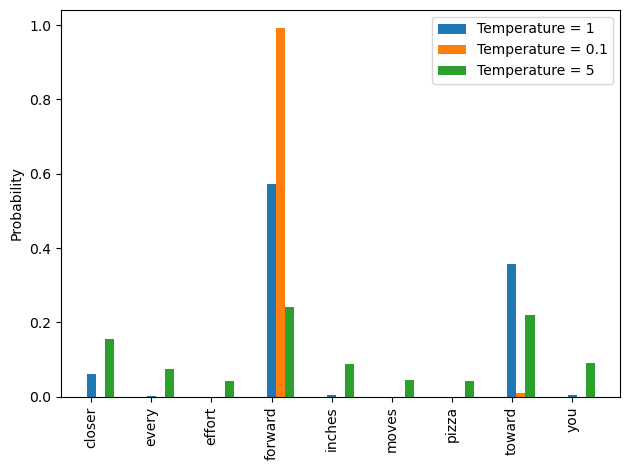

In [70]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    # 条形图的绘制，ax.bar()函数里面的参数分别为条形的x轴位置、高度、宽度、图例标签
    rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()

从上图可以看出，当缩放因子为1的时候，相当于没有进行缩放；而当缩放因子小于1的时候，会让这个概率分布变得更加集中；反之，当缩放因子大于1的时候，会让这个概率分布变得更加均匀。

# 5.3 TopK采样

为了能够使得生成文本更具多样性，并降低无异议句子的出现概率，我们可以降采样的下一个token限制在最有可能出现的K个候选token中：

In [71]:
topk = 3
top_logits, top_pos = torch.topk(logits, topk)
print(f"top logits: {top_logits}")
print(f"top positions: {top_pos}")

top logits: tensor([6.7500, 6.2800, 4.5100])
top positions: tensor([3, 7, 0])


接着，我们可以构造一个类似mask-attention那样的掩码矩阵，用来屏蔽不在K个候选token集合中的其他token：

In [72]:
masked_logits = torch.where(
    condition=logits < top_logits[-1],
    input=torch.tensor(float("-inf")),  # 用来填充不在K个候选token对应的logits元素
    other=logits,  # 其余元素保持不变
)
print(masked_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


最后，继续使用softmax函数将masked_logits转换为概率分布：

In [73]:
topk_probs = torch.softmax(masked_logits, dim=0)
print(topk_probs)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# 5.4 包含温度缩放以及TopK采样的文本生成策略

In [17]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):

    # 循环与之前相同：获取logits，并仅关注最后一步。
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 使用top_k采样对logits值进行过滤
        if top_k is not None:
            # 仅保留top_k的值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # 使用温度缩放
        if temperature > 0.0:
            logits = logits / temperature

            # 使用softmax函数得到概率
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从概率分布中采样
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 否则和之前的generate_simple函数中的处理相同，使用argmax函数取得概率最大的token
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # 和之前相同的序列拼接处理
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [75]:
# 测试一波使用心得生成策略的文本生成函数：
torch.manual_seed(123)

for _ in range(10):
    token_ids = generate(
        model=model,
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=20,
        context_size=model_config["ctx_len"],
        top_k=10,
        temperature=1.5
    )

    print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you in to Gisburn. It--because he had the by his! I was: "I
Output text:
 Every effort moves you know to my way that my, in the to the so with a. And it was his painting
Output text:
 Every effort moves you in the's up that, Mrs. The with't
"I must up and that he was
Output text:
 Every effort moves you of that, and-rooms, of the with the- with that one of her own--and
Output text:
 Every effort moves you?"

".
He he was with a and I felt of a and in him--
Output text:
 Every effort moves you, it to to my, and he was--, it. Gisburn in him my work
Output text:
 Every effort moves you, one of his pictures--, of a he't-hum, in him--as he was
Output text:
 Every effort moves you?"



I felt him--'s an of the me in an and in the fact
Output text:
 Every effort moves you, he to to my dear his he had a his of the that in a flash it the--
Output text:
 Every effort moves you, with him, and in one of the he had with the fact of--because he was no


可以看到，每次生成的文本都已经不再是相同的了。

# 6. 使用`PyTorch`保存和加载模型

## 6.1 保存模型以及优化器

In [76]:
torch.save(
    obj={
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    },
    f="gpt2_small_and_adamw.pth"
)

## 6.2 加载模型

In [78]:
ckpt = torch.load("gpt2_small_and_adamw.pth")

model = GPT2Small(
    vocab_size=model_config["vocab_size"],
    ctx_len=model_config["ctx_len"],
    emb_dim=model_config["emb_dim"],
    n_heads=model_config["n_heads"],
    n_layers=model_config["n_layers"],
    dropout_rate=model_config["dropout_rate"],
    with_bias=model_config["with_bias"],
    with_mask=model_config["with_mask"]
)
model.load_state_dict(ckpt["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
model.train()

GPT2Small(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (decoder): Sequential(
    (0): TransformerDecoderOnly(
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (wq): Linear(in_features=768, out_features=768, bias=False)
        (wk): Linear(in_features=768, out_features=768, bias=False)
        (wv): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerDecoderOn

# 7. 从OpenAI加载预训练权重

## 7.1 下载预训练权重

在运行随书代码的时候我们已经下载过模型权重了，
所以这时候并不需要重新下载，只需要重用之前的权重即可。


In [2]:
import os

models_dir = "gpt2"
model_size = "124M"
model_path = os.path.abspath(
    os.path.join(
        "../",
        "../",
        "Codes",
        "ch05",
        "01_main-chapter-code",
        models_dir,
        model_size
    )
)
print(f"model path: {model_path}")
print(f"model path exists: {os.path.exists(model_path)}")



model path: /Users/eassi/ws/py/llms-from-scratch-cn/Codes/ch05/01_main-chapter-code/gpt2/124M
model path exists: True


In [3]:
import json

import tensorflow as tf

from gpt_download import load_gpt2_params_from_tf_ckpt

tf_ckpt_path = tf.train.latest_checkpoint(model_path)
hparams = json.load(open(os.path.join(model_path, "hparams.json")))
params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, hparams)

In [4]:
print(f"settings: {hparams}")

settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [5]:
print(f"parameter dictionary keys: {params.keys()}")

parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## 7.2 设置实例化GPT2Small模型所需的配置

In [6]:
model_config = hparams.copy()

# 先确认一下模型初始化的参数长什么样：
# help(GPT2Small)

model_config = {
    "vocab_size": hparams["n_vocab"],
    "ctx_len": hparams["n_ctx"],
    "emb_dim": hparams["n_embd"],
    "n_heads": hparams["n_head"],
    "n_layers": hparams["n_layer"],
    "dropout_rate": 0.1, # todo: 需要再确认
    "with_bias": True,
    "with_mask": True
}
from pprint import pprint
pprint(model_config)

{'ctx_len': 1024,
 'dropout_rate': 0.1,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'vocab_size': 50257,
 'with_bias': True,
 'with_mask': True}


## 7.3 加载模型权重

In [11]:
import numpy as np


def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt2, params):
    # Weight tying
    gpt2.pos_emb.weight = assign(gpt2.pos_emb.weight, params['wpe'])
    gpt2.tok_emb.weight = assign(gpt2.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        wq, wk, wv = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt2.decoder[b].mha.wq.weight = assign(gpt2.decoder[b].mha.wq.weight, wq.T)
        gpt2.decoder[b].mha.wk.weight = assign(gpt2.decoder[b].mha.wk.weight, wk.T)
        gpt2.decoder[b].mha.wv.weight = assign(gpt2.decoder[b].mha.wv.weight, wv.T)
    
        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt2.decoder[b].mha.wq.bias = assign(gpt2.decoder[b].mha.wq.bias, q_b)
        gpt2.decoder[b].mha.wk.bias = assign(gpt2.decoder[b].mha.wk.bias, k_b)
        gpt2.decoder[b].mha.wv.bias = assign(gpt2.decoder[b].mha.wv.bias, v_b)
    
        gpt2.decoder[b].mha.out_proj.weight = assign(gpt2.decoder[b].mha.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt2.decoder[b].mha.out_proj.bias = assign(gpt2.decoder[b].mha.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
    
        gpt2.decoder[b].ffn.layers[0].weight = assign(gpt2.decoder[b].ffn.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt2.decoder[b].ffn.layers[0].bias = assign(gpt2.decoder[b].ffn.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt2.decoder[b].ffn.layers[2].weight = assign(gpt2.decoder[b].ffn.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt2.decoder[b].ffn.layers[2].bias = assign(gpt2.decoder[b].ffn.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
    
        gpt2.decoder[b].norm1.scale = assign(gpt2.decoder[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt2.decoder[b].norm1.shift = assign(gpt2.decoder[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt2.decoder[b].norm2.scale = assign(gpt2.decoder[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt2.decoder[b].norm2.shift = assign(gpt2.decoder[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
    
        gpt2.norm.scale = assign(gpt2.norm.scale, params["g"])
        gpt2.norm.shift = assign(gpt2.norm.shift, params["b"])
        gpt2.out.weight = assign(gpt2.out.weight, params["wte"])

OK，现在可以实例化模型并加载权重了！

In [14]:
gpt2 = GPT2Small(
    vocab_size=model_config["vocab_size"],
    ctx_len=model_config["ctx_len"],
    emb_dim=model_config["emb_dim"],
    n_heads=model_config["n_heads"],
    n_layers=model_config["n_layers"],
    dropout_rate=model_config["dropout_rate"],
    with_bias=model_config["with_bias"],
    with_mask=model_config["with_mask"]
)
gpt2.eval()

load_weights_into_gpt(gpt2, params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2.to(device)

GPT2Small(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (decoder): Sequential(
    (0): TransformerDecoderOnly(
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm()
      (mha): MultiHeadAttention(
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerDecoderOnly(
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm()
      (mha)

## 7.4 使用预训练好的模型生成文本

In [22]:
torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
output_ids = generate(
    model=gpt2,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=model_config["ctx_len"],
    top_k=50,
    temperature=1.5
)
output_text = token_ids_to_text(output_ids, tokenizer)
print(f"output text: \n{output_text}")

output text: 
Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


